In [1]:
import libs.utils
import libs.vars
import xarray

In [2]:
ensemble = libs.vars.ensemble()

base_path = '_data/cmip6'
ukesm_file = f'/UKESM1-0-LL/siconc/siconc_SImon_UKESM1-0-LL_ssp585_r2i1p1f2_gn_201501-204912.nc'
ukesm_path = f'{base_path}{ukesm_file}'
ukesm_grid = xarray.open_mfdataset(
    paths=ukesm_path, 
    combine='by_coords',
    use_cftime=True
)

#areacello_kwargs = {
#    'experiment_id': 'piControl',
#    'variable_id': 'areacello',
#    'variant_label': None
#}

regrid_s2d = {
    'grid': ukesm_grid,
    'method': 'nearest_s2d',
    'copy_dims': ['i', 'j', 'longitude', 'latitude', 'vertices']
}
regrid_bil_s2d = {
    'grid': ukesm_grid,
    'method': 'bilinear',
    'extrap_method': 'nearest_s2d',
    'copy_dims': ['i', 'j', 'longitude', 'latitude', 'vertices']
}

experiments = [
    { 'experiment_id': 'historical', 'time_slice': slice('1980-01-01', '2015-01-01') },
    { 'experiment_id': 'ssp585', 'time_slice': slice('2015-01-01', '2101-01-01') },
]
variables = [
    #{ 'variable_id': 'siconc', 'frequency': 'mon', 'regrid_kwargs': regrid_s2d, 'table_id': 'SImon' },
    #{ 'variable_id': 'simass', 'frequency': 'mon', 'regrid_kwargs': regrid_s2d, 'table_id': 'SImon' },
    #{ 'variable_id': 'sithick', 'frequency': 'mon', 'regrid_kwargs': regrid_s2d, 'table_id': 'SImon' },
    #{ 'variable_id': 'sisnthick', 'frequency': 'mon', 'regrid_kwargs': regrid_s2d, 'table_id': 'SImon' },
    #{ 'variable_id': 'pr', 'frequency': 'mon', 'regrid_kwargs': regrid_bil_s2d, 'table_id': 'Amon' },
    #{ 'variable_id': 'prsn', 'frequency': 'mon', 'regrid_kwargs': regrid_bil_s2d, 'table_id': 'Amon' },
    { 'variable_id': 'tas', 'frequency': 'mon', 'regrid_kwargs': regrid_bil_s2d, 'table_id': 'Amon' }
]

In [3]:
plot_variable = 'tas'

for e in experiments:
    for v in variables:
        for i, item in enumerate(ensemble):
            kwargs = { **e, **v }
            kwargs['source_id'] = item['source_id']
            kwargs['variant_label'] = item['variant_label']

            kwargs['force_write'] = False
            kwargs['process_files'] = True
            kwargs['save_to_local'] = True

            file = libs.utils.download_variable(**kwargs)
            if plot_variable == v['variable_id']:
                ensemble[i]['file'] = file

            print('-' * 20)

Requesting:
-> https://esgf-index1.ceda.ac.uk/esg-search/search/?experiment_id=historical&format=application%2Fsolr%2Bjson&grid_label=gn&latest=true&limit=20&mip_era=CMIP6&offset=0&replica=false&source_id=UKESM1-0-LL&type=Dataset&variable_id=tas&frequency=mon&table_id=Amon&variant_label=r2i1p1f2
Results:
-> CMIP6.CMIP.MOHC.UKESM1-0-LL.historical.r2i1p1f2.Amon.tas.gn.v20190502|esgf-data3.ceda.ac.uk
   -> Already exists, skipping: _data/cmip6/UKESM1-0-LL/tas/tas_Amon_UKESM1-0-LL_historical_r2i1p1f2_gn_195001-201412.nc
-> Processing:
   -> Merged
   -> Regridded
   -> Processed file already exists, skipping write
--------------------
Requesting:
-> https://esgf-index1.ceda.ac.uk/esg-search/search/?experiment_id=historical&format=application%2Fsolr%2Bjson&grid_label=gn&latest=true&limit=20&mip_era=CMIP6&offset=0&replica=false&source_id=NorESM2-LM&type=Dataset&variable_id=tas&frequency=mon&table_id=Amon&variant_label=r1i1p1f1
Results:
-> CMIP6.CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Amon.ta

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


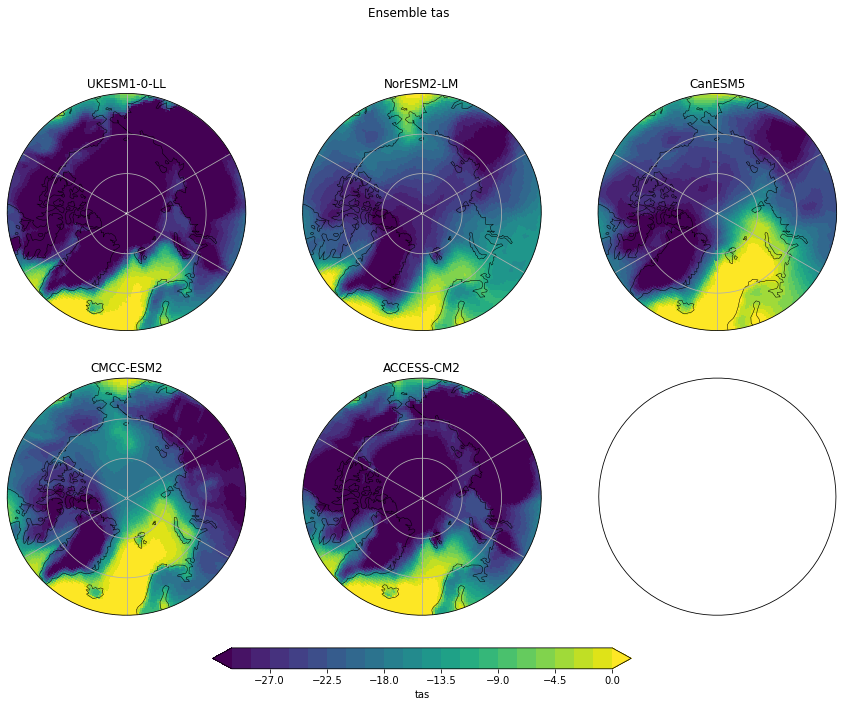

In [4]:
import libs.plot
import warnings
warnings.filterwarnings('ignore')

ensemble_data = []
for item in ensemble:
    if (item['file'] == None):
        continue

    item_data = xarray.open_mfdataset(
        paths=item['file'], 
        combine='by_coords',
        use_cftime=True
    )
    ensemble_data.append({
        'data': item_data[plot_variable][0, :, :] - 273.15,
        'label': item['source_id']
    })

libs.plot.nstereo(
    ensemble_data,
    title=f'Ensemble {plot_variable}',
    colorbar_label=plot_variable,
    colormesh_kwargs={
        'extend': 'both',
        'levels': 21,
        'vmin': -30,
        'vmax': 0,
        'x': 'longitude', 
        'y': 'latitude'
    },
    shape=(2, 3)
)